# Detecting Pneumonia in Chest X-rays
## Introduction
In recent years, convolutional neural networks (CNNs) trained on radiological images such as x-rays have begun to outperform medical professionals in diagnosing disease. [1] Pneumonia, a serious condition where the air sacs in the lungs become filled with fluid or pus, is typically diagnosed by a chest x-ray in conjunction with other clinical measures. [2] In this notebook, I construct, train, and evaluate the performance of a CNN that predicts whether a patient has pneumonia based on a chest x-ray. I walk through the process step by step, including using Keras Tuner to tune the network hyperparameters.

In [1]:
# imports of main packages used
# imports of specific classes and functions appear in the cell in which they are first used
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt  # tune Keras neural network hyperparameters
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

## Dataset
#### Description
The chest x-ray dataset is available from Kaggle. A full description of the collection and quality control methods can be found <a href="https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia">here</a>. [3] It consists of 5,856 .jpeg images of chest x-rays from pediatric patients at a clinic in Guangzhou, China. 1,583 of the x-rays are from healthy patients (labeled as "NORMAL") and the other 4,273 x-rays are from patients with either viral or bacterial pneumonia (labeled as "PNEUMONIA"). Here, I do not make the distinction between viral and bacterial pneumonia, and all pneumonia cases are given the label of "PNEUMONIA."

#### Loading Data
Using `ImageDataGenerator()` and its `flow_from_directory` method [4] from the `tensorflow.keras.preprocessing.image` submodule makes it simple to load image files from a directory. The file hierarchy should have one folder for each class, and within each class folder, there should be one subfolder for training images and another subfolder for test images. Although there is a "val" directory to be used for validation, it contains only 8 examples of each class. This directory was skipped and the validation set was partitioned from the training set, as shown below.

#### Data Augmentation
Data augmentation is the process of introducing some random noise in order to provide a more diverse set of training examples for a model. This is especially important when feeding images to a CNN because deep neural networks require a large number of examples before they are able to detect patterns across them. Some basic transformations that can be used on images are rotation and shifting horizontally or vertically. For the chest x-rays, I introduce only subtle variation in these parameters because the x-rays in the dataset are already more or less centered and straight. It is nonetheless important to augment the dataset so that the model is robust to variations in positioning and anatomy that may exist in x-rays it has not yet seen. The transformations are applied at random to each image on every training epoch. The resources in [5-8] give additional guidance about loading data using `ImageDataGenerator`.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# make an ImageDataGenerator to load training and validation images
generator_train = ImageDataGenerator(validation_split=0.2,
                                     rescale=1/255.,
                                     rotation_range=5,
                                     width_shift_range=0.05,
                                     height_shift_range=0.05)

generator_test = ImageDataGenerator(rescale=1/255.)

In [41]:
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/'

PIXELS = 128
BATCH_SIZE = 32

train_ds = generator_train.flow_from_directory(
    data_dir+'train',
    target_size=(PIXELS, PIXELS),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=0
    )

val_ds = generator_train.flow_from_directory(
    data_dir+'train', # same directory as training data
    target_size=(PIXELS, PIXELS),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    color_mode='rgb',
    shuffle=True,
    seed=0
    )

test_ds = generator_test.flow_from_directory(
    data_dir+'test',
    target_size=(PIXELS, PIXELS),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    seed=0
    )

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [42]:
# setting the class_mode to 'binary' in flow_from_directory replaces the labels with 0/1 - 
# recover which value corresponds to which class
class_dict = train_ds.class_indices
print(class_dict)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [43]:
# number of examples of each class in train, validation, and test partitions
label_dict = {v: k for k, v in class_dict.items()}
datasets = {'train': train_ds, 'validation': val_ds, 'test': test_ds}

for partition, ds in datasets.items():
    counts = pd.Series(ds.classes).value_counts().sort_index()
    counts.index = counts.index.map(label_dict)
    print(partition)
    print(counts)
    print('\n')

train
NORMAL       1073
PNEUMONIA    3100
dtype: int64


validation
NORMAL       268
PNEUMONIA    775
dtype: int64


test
NORMAL       234
PNEUMONIA    390
dtype: int64




## Data Exploration
The subplots below, as used in TensorFlow's classification tutorial, [9] show some examples of x-rays from the training set.

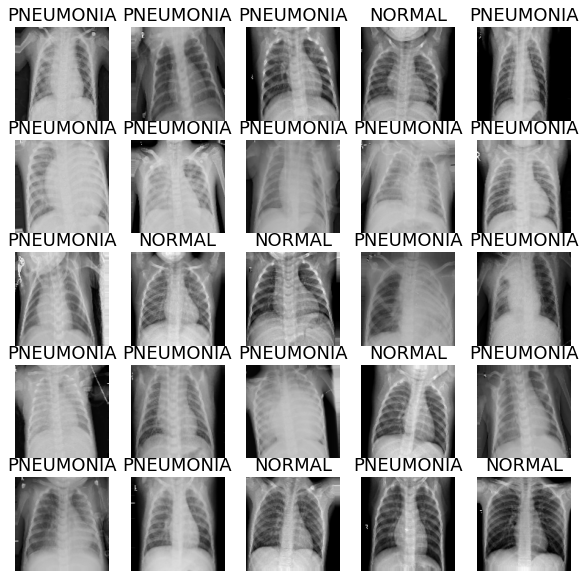

In [44]:
X_train, y_train = next(train_ds)

plt.figure(figsize=(10, 10))

for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    ax.set_box_aspect(1)
    
    plt.imshow(X_train[i])
    label = 'NORMAL' if int(y_train[i]) == 0 else 'PNEUMONIA'
    plt.title(label)
    plt.axis('off')

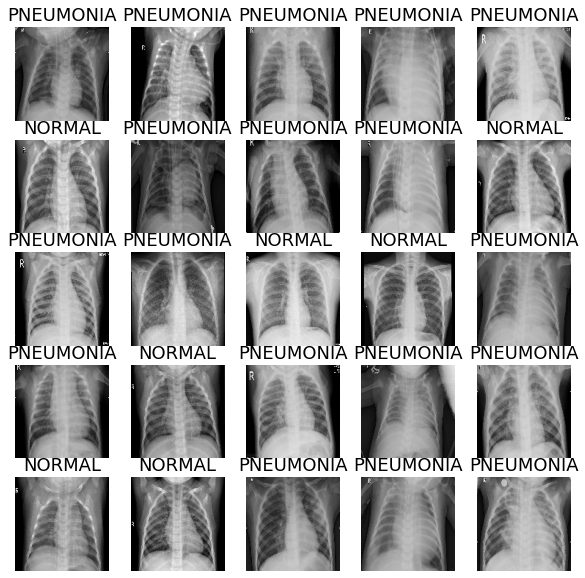

In [45]:
X_test, y_test = next(test_ds)

plt.figure(figsize=(10, 10))

for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    ax.set_box_aspect(1)
    
    plt.imshow(X_test[i])
    label = 'NORMAL' if int(y_test[i]) == 0 else 'PNEUMONIA'
    plt.title(label)
    plt.axis('off')

## Model Training
Keras Tuner is used to create and randomly search a search space of neural network models with varying hyperparameter values. Here, the number of neurons in each layer is varied. The resources in [10] and [11] contain some guidance about how to specify hyperparameter values using the `HyperModel` object from Keras Tuner and the documentation in [12] explains the base `Tuner` class from which specific tuners like `RandomSearch` inherit.

Keras callbacks, which run when certain conditions are met, are used for logging after each epoch [13] and for early stopping during training. Because there are nearly 3 times as many pneumonia x-rays in the training set as there are normal x-rays, class weights are applied to balance the class representation. The accuracy and area under the precision-recall curve (AUCPR) are monitored as performance metrics.

In [6]:
from keras_tuner import HyperModel
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout
)

LAYER_SIZE_MIN = 32
LAYER_SIZE_MAX = 64
KERNEL_SIZE_MIN = 3
KERNEL_SIZE_MAX = 5
MIN_N_LAYERS = 2
MAX_N_LAYERS = 4

class MyHyperModel(HyperModel):
    '''Neural network architecture with a search space of possible hyperparameter values.'''
    
    def build(self, hp):
        '''
        Specify network architecture and possible hyperparameter values.
        
        Args:
            hp: The definitions of the hyperparameters.
        
        Returns:
            The hypermodel.
        
        '''
        model = Sequential()
                
        for layer in range(hp.Int('layers', MIN_N_LAYERS, MAX_N_LAYERS, 1)):
            conv2d_args = {'filters': hp.Int(f'filters_{layer}',
                                 min_value=LAYER_SIZE_MIN, 
                                 max_value=LAYER_SIZE_MAX,
                                 step=32),
                           'kernel_size': hp.Int(f'kernel_{layer}',
                                 min_value=KERNEL_SIZE_MIN,
                                 max_value=KERNEL_SIZE_MAX,
                                 step=1),
                           'activation': 'relu'
                          }
            if layer == 0:
                model.add(Conv2D(**conv2d_args, input_shape=(PIXELS, PIXELS, 3)))
            else:
                model.add(Conv2D(**conv2d_args))
                
            model.add(MaxPooling2D((2, 2)))
            model.add(Dropout(0.2))

        model.add(Flatten())
        
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        
        model.compile(optimizer='RMSprop',
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      metrics=['accuracy', tf.keras.metrics.AUC(curve='PR', name='AUCPR')],
                      weighted_metrics=['accuracy', tf.keras.metrics.AUC(curve='PR', name='AUCPR')])
        
        return model

In [7]:
# balance normal vs. pneumonia classes for training
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=[0,1], y=train_ds.labels)
class_weights = dict(enumerate(class_weights))

In [8]:
class LogCallback(tf.keras.callbacks.Callback):
    '''Performance metrics saved during model training.'''
    def on_train_begin(self, logs={}):
        '''Initialize arrays to store metrics specified in logs.'''
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
    def on_epoch_end(self, epoch, logs={}):
        '''Store the specified metrics at the end of every epoch.'''
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

In [9]:
from tensorflow.keras.callbacks import CSVLogger

# instantiate callbacks
log_callback = LogCallback()
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
csv_logger = CSVLogger('/kaggle/working/history_log.csv', append=True)

hypermodel = MyHyperModel()

tuner_rs = kt.RandomSearch(
            hypermodel,
            objective=kt.Objective('val_loss', direction='min'),
            seed=0,
            max_trials=10,
            executions_per_trial=1,
            overwrite=True,
            directory='kaggle/working',
            project_name='pneumonia_model_mini'
            )

In [10]:
accelerator_type = 'GPU'

if accelerator_type == 'GPU':
    accelerator = tf.device('/GPU:0')

In [11]:
# train model using Keras Tuner or load best model from previous random search
train_model = False

if train_model:
    with accelerator:
        tuner_rs.search(train_ds,
            epochs=20,
            verbose=1,
            validation_data=val_ds,
            class_weight=class_weights,
            callbacks=[log_callback,
                       early_stop_callback,
                       csv_logger]
            )
        
    # save trained Keras Tuner object
    with open('/kaggle/working/tuner-search.pkl', 'wb') as f:
        pkl.dump(tuner_rs, f)

    # gets the best model from the random search
    model = tuner_rs.get_best_models(1)[0]
    model.summary()

    # save best model
    model.save('model.keras')

    # view hyperparameters of best model
    tuner_rs.get_best_hyperparameters(1)[0].values
    
else:
    model = keras.models.load_model('/kaggle/input/pneumonia-model/model.keras')
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        1

In [12]:
# load trained Keras Tuner object and history
# with open('/kaggle/working/tuner-search.pkl', 'rb') as f:
#     tuner_rs = pkl.load(f)

# history = pd.read_csv('/kaggle/working/history_log.csv')
# history

## Evaluate Performance
For a medical test designed to diagnose disease, it is crucial to maximize the percentage of positive patients who are classified as positives (**recall**, or **sensitivity**), but it is also important to minimize false positives by maximizing **precision**, or **positive predictive value**. Because the CNN outputs a continuous value between 0 and 1 to represent the probability that an x-ray is from a pneumonia patient, the cutoff for a sample to be classified as pneumonia can be empirically chosen. I aim to detect at least 90% of pneumonia cases without letting an excessive number of normal x-rays get wrongly labeled as pneumonia. The chosen model identifies 95% (381/390) of pneumonia cases as pneumonia while incorrectly labeling 22% (51/234) of normal x-rays as pneumonia for an overall accuracy of 89%.

In [13]:
model.evaluate(test_ds, verbose=1)

y_test = test_ds.labels

# get a value between 0 and 1 from sigmoid activation representing probability 
# that example belongs to pneumonia class
y_pred = model.predict(test_ds)

20/20 [==============================] - 17s 395ms/step - loss: 0.8289 - accuracy: 0.8045 - AUCPR: 0.8949 - weighted_accuracy: 0.8045 - weighted_AUCPR: 0.8949


In [14]:
mpl.rc('axes', titlesize=18, labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
GRAPH_SIZE = (8, 6)

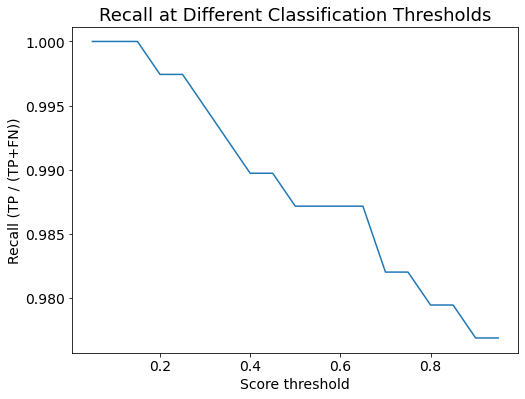

In [15]:
thresholds = np.arange(0.05, 1, 0.05).tolist()

# minimize false negatives = maximize recall / sensitivity (TP / (TP+FN))
m = tf.keras.metrics.Recall(thresholds=thresholds)
m.update_state(y_test,y_pred)
recall = m.result().numpy()

fig, ax = plt.subplots(1, 1, figsize=GRAPH_SIZE)
sns.lineplot(x=thresholds, y=recall, ax=ax)
plt.xlabel('Score threshold')
plt.ylabel('Recall (TP / (TP+FN))')
plt.title('Recall at Different Classification Thresholds', fontsize=18);

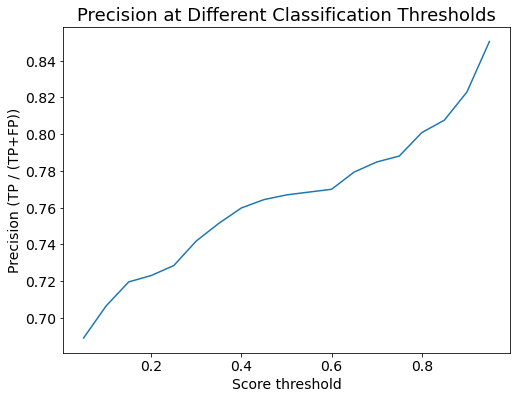

In [16]:
# maximize positive predictive value (precision, TP / (TP+FP))
m = tf.keras.metrics.Precision(thresholds=thresholds)
m.update_state(y_test,[x for x in y_pred])
precision = m.result().numpy()

fig, ax = plt.subplots(1, 1, figsize=GRAPH_SIZE)
sns.lineplot(x=thresholds, y=precision, ax=ax)
plt.xlabel('Score threshold')
plt.ylabel('Precision (TP / (TP+FP))')
plt.title('Precision at Different Classification Thresholds');

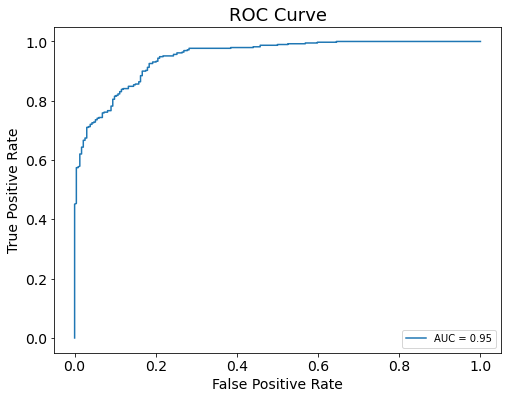

In [17]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

fig, ax = plt.subplots(1, 1, figsize=GRAPH_SIZE)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
curve = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
curve.plot(ax=ax)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve');

In [18]:
# transform to a binary prediction with empirically chosen threshold
prob = np.array([x[0] for x in y_pred])
threshold = 0.98
y_pred_binary = [1 if x > threshold else 0 for x in prob]

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84       234
           1       0.88      0.95      0.91       390

    accuracy                           0.89       624
   macro avg       0.89      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



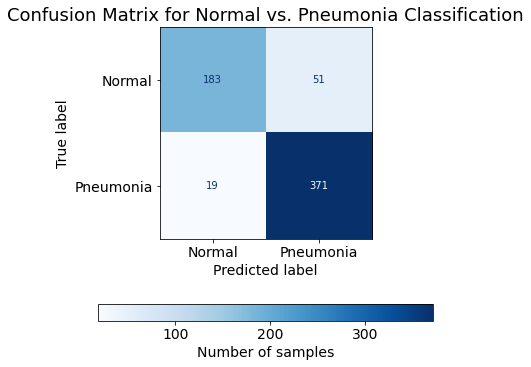

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred_binary)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
cm_plot.plot(cmap='Blues', ax=ax)
im = cm_plot.im_
im.colorbar.remove()
plt.colorbar(im, orientation='horizontal', pad=0.2, label='Number of samples')

plt.title('Confusion Matrix for Normal vs. Pneumonia Classification');

Average precision score: 0.8667654028436019


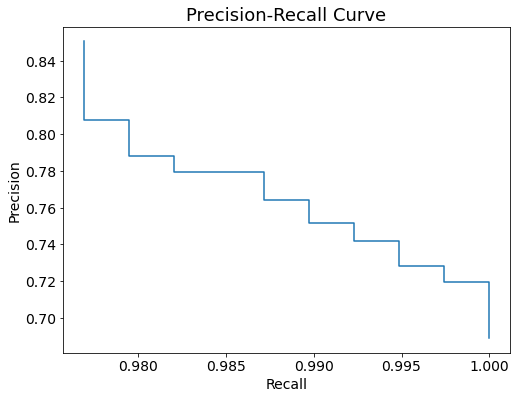

In [21]:
from sklearn.metrics import average_precision_score, PrecisionRecallDisplay

print(f'Average precision score: {average_precision_score(y_test, y_pred_binary)}')

fig, ax = plt.subplots(1, 1, figsize=GRAPH_SIZE)
PrecisionRecallDisplay(precision, recall).plot(ax=ax)
plt.title('Precision-Recall Curve');

## Peeking Inside the Black Box
While CNNs are not very transparent models, we can look at correctly vs. incorrectly classified examples and visualize the filters and activation maps to better understand how the pneumonia classifier is making a diagnosis. Comparing samples that the classifier predicted to be pneumonia versus samples predicted to be normal, and with what amount of confidence, provides insight on what visual features the classifier is using to make its predictions. Looking at the filters shows us what local low-level patterns the classifier considers important and the activation maps translate those small patterns into a full-scale filtered view of each image. The tutorial in [14] shows how to plot filters and activations.

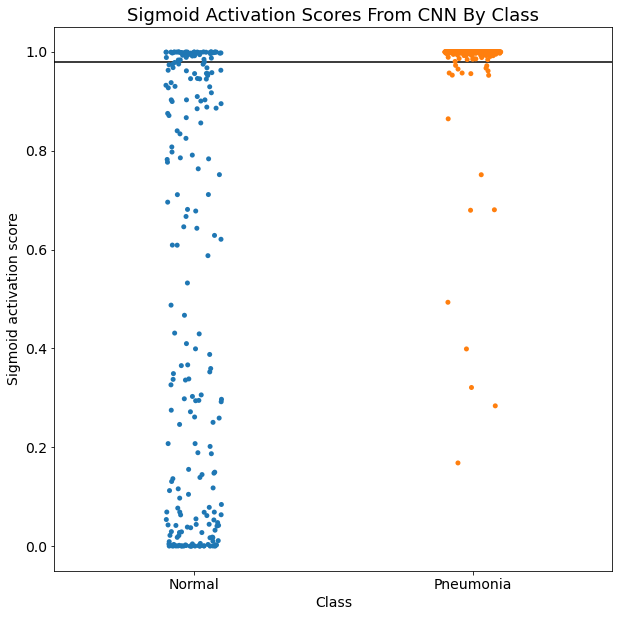

In [22]:
# plot sigmoid activation scores (0-1) by class, representing classifier's confidence in its predictions

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.stripplot(x=y_test, y=prob)

plt.xlabel('Class')
ax.set_xticklabels(['Normal', 'Pneumonia'])
plt.ylabel('Sigmoid activation score')

plt.axhline(threshold, color='k')
plt.title('Sigmoid Activation Scores From CNN By Class');

In [23]:
X_test = np.concatenate([test_ds.next()[0] for i in range(test_ds.__len__())])
n_test = X_test.shape[0]

In [24]:
# visually inspecting correctly vs. incorrectly classified examples

# number of examples to plot
n = 5

normal = y_test==0
X_test_normal = X_test[normal]
prob_normal = prob[normal]

X_test_pneumonia = X_test[~normal]
prob_pneumonia = prob[~normal]

sorted_normal = np.argsort(prob_normal)
bottom_normal = sorted_normal[:n]
top_normal = sorted_normal[-n:]
normal_low_pneumonia = X_test_normal[bottom_normal]
normal_high_pneumonia = X_test_normal[top_normal]

sorted_pneumonia = np.argsort(prob_pneumonia)
bottom_pneumonia = sorted_pneumonia[:n]
top_pneumonia = sorted_pneumonia[-n:]
pneumonia_low_pneumonia = X_test_pneumonia[bottom_pneumonia]
pneumonia_high_pneumonia = X_test_pneumonia[top_pneumonia]

In [25]:
XRAY_PLOT_SIZE = (10, 6)

def plot_xrays(x, label, title):
    fig = plt.figure(figsize=XRAY_PLOT_SIZE)
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        ax.set_box_aspect(1)

        plt.imshow(x[i])
        plt.title(label)
        plt.axis("off")
    
    fig.suptitle(title, fontsize=18)
    fig.subplots_adjust(top=1.4) # decrease space between suptitle and plots
    
    plt.show()

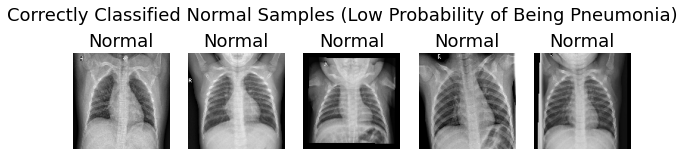

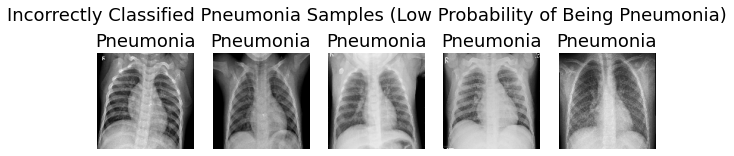

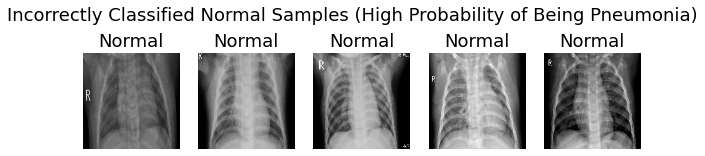

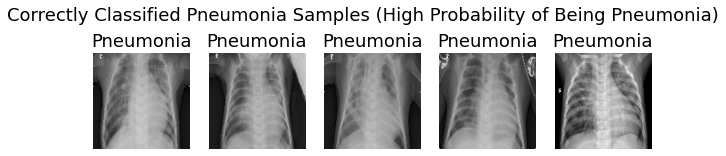

In [26]:
# examples assigned low probability of being pneumonia
# true negatives
plot_xrays(normal_low_pneumonia,
           'Normal',
           'Correctly Classified Normal Samples (Low Probability of Being Pneumonia)')

# false negatives
plot_xrays(pneumonia_low_pneumonia,
           'Pneumonia',
           'Incorrectly Classified Pneumonia Samples (Low Probability of Being Pneumonia)')

# examples assigned high probability of being pneumonia
# true positives
plot_xrays(normal_high_pneumonia,
           'Normal',
           'Incorrectly Classified Normal Samples (High Probability of Being Pneumonia)')

# false positives
plot_xrays(pneumonia_high_pneumonia,
           'Pneumonia',
           'Correctly Classified Pneumonia Samples (High Probability of Being Pneumonia)')

In [27]:
from tensorflow.keras.models import Model

# make into an array of a single image
image = np.expand_dims(normal_low_pneumonia[0], axis=0)

conv_layer_inds = np.where(['conv' in x.name for x in model.layers])[0]
outputs = [model.layers[i].output for i in conv_layer_inds]
layer_model = Model(inputs=model.inputs , outputs=outputs)

In [28]:
def plot_filters(filters, layer):
    n = filters.shape[-1]
    ix=1
    fig = plt.figure(figsize=(6, 6))
    for i in range(n):
        f = filters[:, :, :, i]
        for j in range(n):
            # subplot for n filters and 3 channels
            plt.subplot(3, 3, ix)
            plt.imshow(f[:, :, j], cmap='gray')
            ix += 1
            plt.axis('off')
        fig.suptitle(f'Conv Layer {layer}', fontsize=18)

    plt.show()

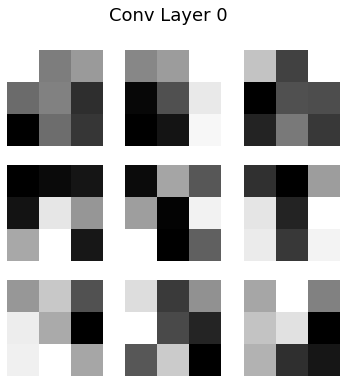

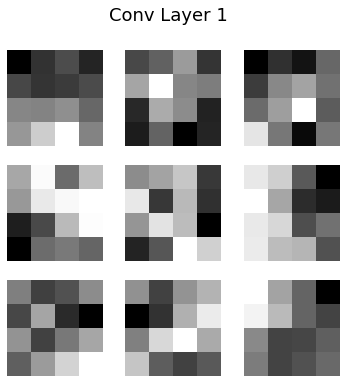

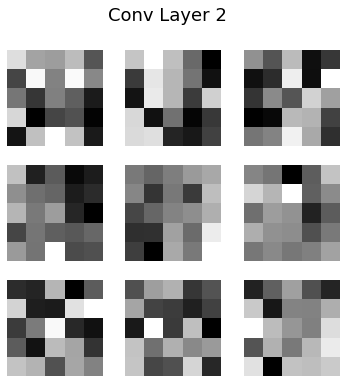

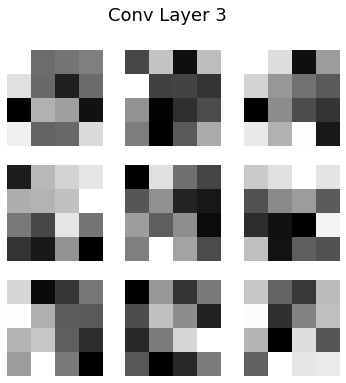

In [29]:
# visualize first n filters for each conv layer
n_filters = 3

for i, layer in enumerate(conv_layer_inds):
    filters, bias = model.layers[layer].get_weights()

    # normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters_norm = (filters - f_min) / (f_max - f_min)

    plot_filters(filters_norm[:, :, :, :n_filters], i)

In [30]:
def plot_activation_maps(activations, layer):
    fig = plt.figure(figsize=(20, 15))
    n_activations = activations.shape[-1]
    for i in range(1, n_activations+1):
        plt.subplot(8, 8, i)
        plt.imshow(activations[0, :, :, i-1] , cmap='gray')
    fig.suptitle(f'Conv Layer {layer}', fontsize=18)
    fig.subplots_adjust(top=0.95) # decrease space between suptitle and plots

    plt.show()

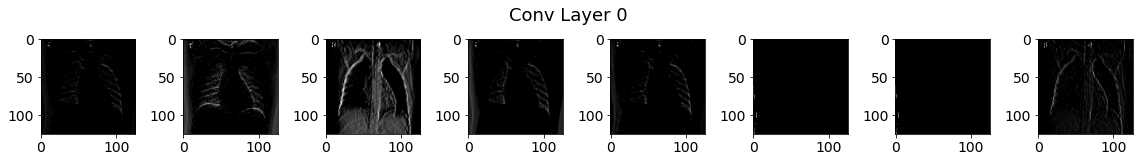

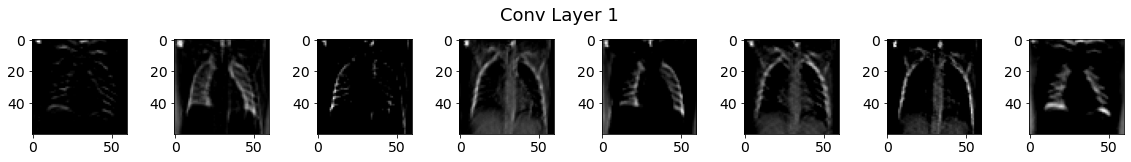

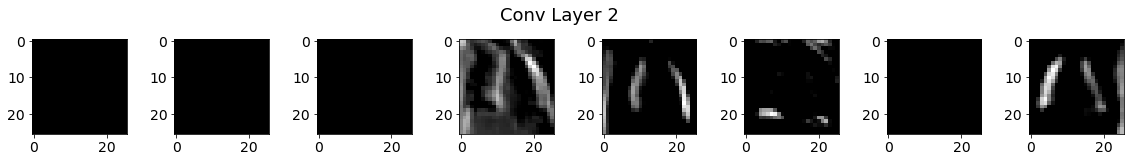

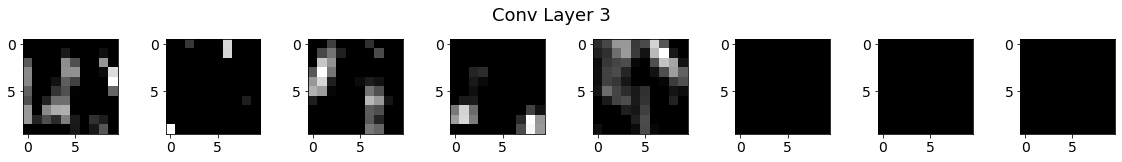

In [31]:
# visualize first n activation maps of each layer
activation_maps = layer_model.predict(image)
n_amaps = 8

for i, amap in enumerate(activation_maps):
    plot_activation_maps(amap[:, :, :, :n_amaps], i)

## Citations
[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8112196/ \
[2] https://www.nhlbi.nih.gov/health/pneumonia \
[3] https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia \
[4] 
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory \
[5] https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator \
[6] https://datascience.stackexchange.com/questions/113449/what-does-shuffle-and-seed-parameter-in-keras-image-gen-flow-from-directory-si \
[7] https://www.tensorflow.org/tutorials/load_data/images \
[8] https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720 \
[9] https://www.tensorflow.org/tutorials/keras/classification \
[10] https://pythonprogramming.net/keras-tuner-optimizing-neural-network-tutorial/ \
[11] https://towardsdatascience.com/hyperparameter-tuning-with-keras-tuner-283474fbfbe \
[12] https://keras.io/api/keras_tuner/tuners/base_tuner/#tuner-class \
[13] https://medium.com/geekculture/how-to-plot-model-loss-while-training-in-tensorflow-9fa1a1875a5 \
[14] https://www.kaggle.com/code/arpitjain007/guide-to-visualize-filters-and-feature-maps-in-cnn
